# Imports

In [1]:
%load_ext autoreload
import sys

sys.path.append('..')

In [2]:
%autoreload

import itertools, os, time, pickle, pandas as pd, matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from chexpert_approximator.data_processor import *
from chexpert_approximator.run_classifier import *

from chexpert_approximator.reload_and_get_logits import *

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
# We can't display MIMIC-CXR Output:

DO_BLIND = True
def blind_display(df):
    if DO_BLIND:     
        df = df.copy()
        index_levels = df.index.names
        df.reset_index('rad_id', inplace=True)
        df['rad_id'] = [0 for _ in df['rad_id']]
        df.set_index('rad_id', append=True, inplace=True)
        df = df.reorder_levels(index_levels, axis=0)

        for c in df.columns:
            if pd.api.types.is_string_dtype(df[c]): df[c] = ['SAMPLE' for _ in df[c]]
            else: df[c] = np.NaN

    display(df.head())

# Load the Data

In [4]:
DATA_DIR = '/scratch/chexpert_approximator/processed_data/' # INSERT YOUR DATA DIR HERE!
# DATA MUST BE STORED IN A FILE `inputs.hdf` under key `with_folds`.
INPUT_PATH, INPUT_KEY = os.path.join(DATA_DIR, 'inputs.hdf'), 'with_folds'

# YOUR CLINICAL BERT MODEL GOES HERE
BERT_MODEL_PATH = (
    '/data/medg/misc/clinical_BERT/cliniBERT/models/pretrained_bert_tf/bert_pretrain_output_all_notes_300000/'
)

# THIS IS WHERE YOUR PRE-TRAINED CHEXPERT++ MODEL LIVES
PRETRAINED_CXPPP_PATH = '/crimea/mmd/CheXpert_Approximator/out/run_1'

# DON'T MODIFY THESE
FOLD = 'Fold'

KEY = {
    0: 'No Mention',
    1: 'Uncertain Mention',
    2: 'Negative Mention',
    3: 'Positive Mention',
}
INV_KEY = {v: k for k, v in KEY.items()}
SENT_NUM = 'Sentence Number'

In [5]:
ALL_TASKS = ['Lung Lesion',
 'Pleural Effusion',
 'Atelectasis',
 'Enlarged Cardiomediastinum',
 'Airspace Opacity',
 'Fracture',
 'Cardiomegaly',
 'Edema',
 'No Finding',
 'Support Devices',
 'Pneumonia',
 'Pleural Other',
 'Pneumothorax',
 'Consolidation']

In [6]:
inputs = pd.read_hdf(INPUT_PATH, INPUT_KEY)
label_cols = [col for col in inputs.index.names if col not in ('rad_id', FOLD)]

In [7]:
sentence_num = pd.Series(index=inputs.index, data=1)
sentence_num = sentence_num.groupby('rad_id').cumsum()

inputs[SENT_NUM] = sentence_num
inputs.set_index(SENT_NUM, append=True, inplace=True)

In [8]:
print('Read %d sentences with %d labels: %s' % (len(inputs), len(label_cols), str(label_cols)))
print("Input has multi-index with columns: %s" % ', '.join(inputs.index.names))
print("Input has columns: %s" % ', '.join(inputs.columns))

blind_display(inputs)

Read 753611 sentences with 14 labels: ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Lesion', 'Airspace Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
Input has multi-index with columns: rad_id, No Finding, Enlarged Cardiomediastinum, Cardiomegaly, Lung Lesion, Airspace Opacity, Edema, Consolidation, Pneumonia, Atelectasis, Pneumothorax, Pleural Effusion, Pleural Other, Fracture, Support Devices, Fold, Sentence Number
Input has columns: sentence


sentence
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly Lung Lesion Airspace Opacity Edema      Consolidation Pneumonia  Atelectasis Pneumothorax Pleural Effusion Pleural Other Fracture   Support Devices Fold Sentence Number         
0      Positive Mention No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention   No Mention       No Mention    No Mention No Mention      6    1                 SAMPLE
                        Negative Mention           No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention   No Mention       No Mention    No Mention No Mention      6    2                 SAMPLE
                        No Mention                 No Mention   No Mention  No Mention       No Mention No Mention    No Mention No Mention  No Mention   No Mention       No Mention    No Mention No Mention      6    3                 SAMPLE
                                                                                                                                                                                                                    4    1                 SAMPLE
       No Mention       No Mention                 No Mention   No Mention  Positive Mention No Mention No Mention    No Mention No Mention  No Mention   No Mention       No Mention    No Mention No Mention      4    2                 SAMPLE

# Model
## Data Processor

In [22]:
INV_KEY

{'No Mention': 0,
 'Uncertain Mention': 1,
 'Negative Mention': 2,
 'Positive Mention': 3}

In [23]:
K = 10

# TODO(mmd): This is a bit redundant, and could be moved to the library code and shared across notebooks.
class CheXpertProcessor(DataProcessor):
    def __init__(self, tuning_fold, held_out_fold):
        super().__init__()
        self.tuning_fold, self.held_out_fold = tuning_fold, held_out_fold
    
    """Processor for the CheXpert approximator.
    Honestly this is kind of silly, as it never stores internal state."""
    def get_train_examples(self, df): return self._create_examples(
        df, set([f for f in range(K) if f not in (self.tuning_fold, self.held_out_fold)])
    )
    def get_dev_examples(self, df):   return self._create_examples(df, set([self.tuning_fold]))
    def get_examples(self, df, folds=[]): return self._create_examples(df, set(folds))
    
    def get_labels(self): return {label: list(range(4)) for label in label_cols}

    def _create_examples(self, df, folds):
        """Creates examples for the training and dev sets."""
        df = df[df.index.get_level_values(FOLD).isin(folds)]
        lmap = {l: i for i, l in enumerate(df.index.names)}
        
        examples = []
        for idx, r in df.iterrows():
            labels = {l: INV_KEY[idx[lmap[l]]] if idx[lmap[l]] in INV_KEY else -100 for l in label_cols}
            
            examples.append(InputExample(
                guid=str(idx[lmap['rad_id']]), text_a=r.sentence, text_b=None, label=labels
            ))
        return examples

## Running the Model

In [24]:
processor = CheXpertProcessor(8, 9)
# train_examples = processor.get_train_examples(inputs)
# dev_examples = processor.get_dev_examples(inputs)

In [25]:
start = time.time()
model, logits, results = reload_and_get_logits(
    restricted_fold_8_inputs,n
    bert_model      = BERT_MODEL_PATH,
    processor       = processor,
    task_dimensions = {l: 4 for l in label_cols},
    output_dir      = PRETRAINED_CXPPP_PATH,
    gpu             = '0,1,2,3',
    seed            = 42,
    do_lower_case   = False,
    max_seq_length  = 128,
    batch_size      = 256,
    processor_args  = {'folds': [8]},
)
end = time.time()

print(results, end - start)

/data/medg/misc/clinical_BERT/cliniBERT/models/pretrained_bert_tf/bert_pretrain_output_all_notes_300000/
Max Sequence Length: 95



{'eval_loss': 0.1032366114750243, 'eval_accuracy': 0.9981117935756904} 418.14262771606445


In [15]:
logits_dfs = {k: pd.DataFrame(
    np.vstack(v), columns=[KEY[i] for i in range(4)],
    index=inputs[inputs.index.get_level_values(FOLD).isin([8])].index
) for k, v in logits.items()}

for k, df in logits_dfs.items():
    df.columns = pd.MultiIndex.from_tuples([(k, c) for c in df.columns], names=('Task', 'Label'))
logits_df = pd.concat(logits_dfs.values(), axis=1)

In [17]:
chexpert_time = 2 + 57/60 + (7/60)/60 # in hours
chexpertPP_time = (end - start) / (60**2) * 10 # in hours

print(
    "Total time was %.2f v. %.2f (CXB takes %.2f %% as long)" % (
        chexpertPP_time, chexpert_time, (chexpertPP_time / chexpert_time) * 100
    )
)

Total time was 1.59 v. 2.95 (CXB takes 54.00 % as long)


In [43]:
print("Produced %d %d-dim Logits in %.2f min." % (logits_df.shape[0], logits_df.shape[1], 60*chexpertPP_time/10))
blind_display(logits_df)

Produced 75748 56-dim Logits in 9.56 min.


Task                                                                                                                                                                                                                                                No Finding  \
Label                                                                                                                                                                                                                                               No Mention   
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly     Lung Lesion Airspace Opacity Edema      Consolidation    Pneumonia  Atelectasis Pneumothorax     Pleural Effusion Pleural Other Fracture   Support Devices Fold Sentence Number              
0      Positive Mention No Mention                 No Mention       No Mention  No Mention       No Mention No Mention       No Mention No Mention  No Mention       No Mention       No Mention    No Mention No Mention      8    1                      NaN   
       No Mention       No Mention                 Positive Mention No Mention  No Mention       No Mention No Mention       No Mention No Mention  No Mention       No Mention       No Mention    No Mention No Mention      8    2                      NaN   
                        Uncertain Mention          No Mention       No Mention  No Mention       No Mention No Mention       No Mention No Mention  No Mention       No Mention       No Mention    No Mention No Mention      8    3                      NaN   
       Positive Mention No Mention                 No Mention       No Mention  No Mention       No Mention Negative Mention No Mention No Mention  Negative Mention Negative Mention No Mention    No Mention No Mention      8    4                      NaN   
                                                                                                            No Mention       No Mention No Mention  No Mention       No Mention       No Mention    No Mention No Mention      8    5                      NaN   

Task                                                                                                                                                                                                                                                                   \
Label                                                                                                                                                                                                                                               Uncertain Mention   
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly     Lung Lesion Airspace Opacity Edema      Consolidation    Pneumonia  Atelectasis Pneumothorax     Pleural Effusion Pleural Other Fracture   Support Devices Fold Sentence Number                     
0      Positive Mention No Mention                 No Mention       No Mention  No Mention       No Mention No Mention       No Mention No Mention  No Mention       No Mention       No Mention    No Mention No Mention      8    1                             NaN   
       No Mention       No Mention                 Positive Mention No Mention  No Mention       No Mention No Mention       No Mention No Mention  No Mention       No Mention       No Mention    No Mention No Mention      8    2                             NaN   
                        Uncertain Mention          No Mention       No Mention  No Mention       No Mention No Mention       No Mention No Mention  No Mention       No Mention       No Mention    No Mention No Mention      8    3                             NaN   
       Positive Mention No Mention                 No Mention       No Mention  No Mention       No Mention Negative Mention No Mention No Mention  Negative Mention Negative Mention No Mention    No Mention No Mention      8    4                             NaN   
                                                                                

## Relabeling Set

In [44]:
idx = pd.IndexSlice

sents = {}
for task in frequencies.index:
    sents[task] = {}
    for label in frequencies.columns:
        df = inputs[inputs.index.get_level_values(task) == label]
        N = len(df)
        print(task, label, df.shape)
        
        if not N:
            sents[task][label] = df.loc[[]]
            continue
            
        rows = np.random.choice(N, 10)
        sents[task][label] = df.iloc[rows]

No Finding No Mention (252836, 1)
No Finding Uncertain Mention (0, 1)
No Finding Positive Mention (500775, 1)
No Finding Negative Mention (0, 1)
Enlarged Cardiomediastinum No Mention (665435, 1)
Enlarged Cardiomediastinum Uncertain Mention (17765, 1)
Enlarged Cardiomediastinum Positive Mention (12147, 1)
Enlarged Cardiomediastinum Negative Mention (58264, 1)
Cardiomegaly No Mention (682587, 1)
Cardiomegaly Uncertain Mention (3522, 1)
Cardiomegaly Positive Mention (38872, 1)
Cardiomegaly Negative Mention (28630, 1)
Lung Lesion No Mention (746383, 1)
Lung Lesion Uncertain Mention (693, 1)
Lung Lesion Positive Mention (5582, 1)
Lung Lesion Negative Mention (953, 1)
Airspace Opacity No Mention (692523, 1)
Airspace Opacity Uncertain Mention (3351, 1)
Airspace Opacity Positive Mention (52305, 1)
Airspace Opacity Negative Mention (5432, 1)
Edema No Mention (707399, 1)
Edema Uncertain Mention (7951, 1)
Edema Positive Mention (12991, 1)
Edema Negative Mention (25270, 1)
Consolidation No Mention

In [45]:
task_dfs = {}
for task, labels_dict in sents.items():
    task_dfs[task] = pd.concat(labels_dict.values()).sample(frac=1)
    task_dfs[task].to_csv(os.path.join(DATA_DIR, '%s_held_out.csv' % task), sep='\t')

In [47]:
blind_display(task_dfs['Pneumonia'])

sentence
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly Lung Lesion Airspace Opacity Edema      Consolidation    Pneumonia         Atelectasis       Pneumothorax Pleural Effusion Pleural Other Fracture   Support Devices Fold Sentence Number         
0      No Mention       No Mention                 No Mention   No Mention  Negative Mention No Mention No Mention       Positive Mention  No Mention        No Mention   No Mention       No Mention    No Mention No Mention      8    4                 SAMPLE
                                                                            No Mention       No Mention Positive Mention Positive Mention  No Mention        No Mention   No Mention       No Mention    No Mention No Mention      0    2                 SAMPLE
                                                                            Positive Mention No Mention No Mention       Positive Mention  Uncertain Mention No Mention   No Mention       No Mention    No Mention No Mention      3    5                 SAMPLE
       Positive Mention No Mention                 No Mention   No Mention  No Mention       No Mention No Mention       Negative Mention  No Mention        No Mention   No Mention       No Mention    No Mention No Mention      8    6                 SAMPLE
       No Mention       No Mention                 No Mention   No Mention  Positive Mention No Mention No Mention       Uncertain Mention No Mention        No Mention   No Mention       No Mention    No Mention No Mention      5    1                 SAMPLE

In [48]:
task_labels_per_sent = defaultdict(list)
for task, label_dict in sents.items():
    for label, df in label_dict.items():
        for sent in df.sentence:
            task_labels_per_sent[sent].append((task, label))

In [49]:
len(task_labels_per_sent)

515

In [50]:
Counter(len(v) for k, v in task_labels_per_sent.items())

Counter({1: 494, 2: 18, 3: 2, 4: 1})

## Active Learning

### Measuring against a held out set

In [51]:
ALL_TASKS = [n for n in inputs.index.names if n not in ('rad_id', FOLD, SENT_NUM)]
print(ALL_TASKS)held_out_dir = '/scratch/chexpert_approximator/labels_annotator_1/held_out'
held_out_labels = {}
for fn in os.listdir(held_out_dir):
    task = fn[:-4]
    held_out_labels[task] = pd.read_csv(os.path.join(held_out_dir, fn))

In [52]:
annotator_2_held_out_dir = '/scratch/chexpert_approximator/labels_annotator_2/held_out'
annotator_2_held_out_labels = {}
for fn in os.listdir(annotator_2_held_out_dir):
    task = fn[:-4]
    annotator_2_held_out_labels[task] = pd.read_csv(os.path.join(annotator_2_held_out_dir, fn))

In [56]:
inter_annotator_agreement = {}
for task in ALL_TASKS:
    t = task.replace(' ', '_').lower()
    agree = (held_out_labels[t].Annotation == annotator_2_held_out_labels[t].Annotation).mean()
    print(
        "Agreement percentage for %s: %.2f%%" 
        "" % (task, agree * 100)
    )
    inter_annotator_agreement[t] = agree

Agreement percentage for No Finding: 80.00%
Agreement percentage for Enlarged Cardiomediastinum: 82.50%
Agreement percentage for Cardiomegaly: 95.00%
Agreement percentage for Lung Lesion: 55.00%
Agreement percentage for Airspace Opacity: 70.00%
Agreement percentage for Edema: 65.00%
Agreement percentage for Consolidation: 87.50%
Agreement percentage for Pneumonia: 80.00%
Agreement percentage for Atelectasis: 85.00%
Agreement percentage for Pneumothorax: 80.00%
Agreement percentage for Pleural Effusion: 92.50%
Agreement percentage for Pleural Other: 72.50%
Agreement percentage for Fracture: 65.00%
Agreement percentage for Support Devices: 85.00%


In [61]:
faked_inputs = inputs.copy()
faked_inputs.reset_index('Fold', inplace=True)
rad_ids_and_sents = {t: i for i, t in enumerate(zip(
    inputs.index.get_level_values('rad_id'), inputs.index.get_level_values('Sentence Number')
))}

all_idxs = set()
for task, df in held_out_labels.items():
    all_idxs.update([rad_ids_and_sents[(r, s)] for r, s in df[['rad_id', 'Sentence Number']].values])
    
faked_inputs = faked_inputs.iloc[list(all_idxs)]
faked_inputs['Fold'] = 8
faked_inputs.set_index('Fold', append=True, inplace=True)

start = time.time()
_, held_out_logits, _ = reload_and_get_logits(
    faked_inputs,
    bert_model      = BERT_MODEL_PATH,
    processor       = processor,
    task_dimensions = {l: 4 for l in label_cols},
    output_dir      = PRETRAINED_CXPPP_PATH,
    gpu             = '0,1,2,3',
    seed            = 42,
    do_lower_case   = False,
    max_seq_length  = 128,
    batch_size      = 256,
    processor_args  = {'folds': [8]},
    model           = model
)
end = time.time()

held_out_logits_dfs = {k: pd.DataFrame(
    np.vstack(v), columns=[KEY[i] for i in range(4)],
    index=faked_inputs[faked_inputs.index.get_level_values(FOLD).isin([8])].index
) for k, v in held_out_logits.items()}

for k, df in held_out_logits_dfs.items():
    df.columns = pd.MultiIndex.from_tuples([(k, c) for c in df.columns], names=('Task', 'Label'))
held_out_logits_df = pd.concat(held_out_logits_dfs.values(), axis=1)

/data/medg/misc/clinical_BERT/cliniBERT/models/pretrained_bert_tf/bert_pretrain_output_all_notes_300000/
Max Sequence Length: 57


In [62]:
blind_display(held_out_logits_df.head())

Task                                                                                                                                                                                                                                                                       No Finding  \
Label                                                                                                                                                                                                                                                                      No Mention   
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly Lung Lesion      Airspace Opacity Edema             Consolidation    Pneumonia         Atelectasis      Pneumothorax     Pleural Effusion Pleural Other    Fracture   Support Devices Sentence Number Fold              
0      No Mention       No Mention                 No Mention   Negative Mention No Mention       No Mention        Negative Mention Uncertain Mention No Mention       No Mention       No Mention       No Mention       No Mention No Mention      2               8           NaN   
       Positive Mention No Mention                 No Mention   No Mention       No Mention       No Mention        No Mention       No Mention        No Mention       Negative Mention No Mention       No Mention       No Mention No Mention      3               8           NaN   
       No Mention       No Mention                 No Mention   No Mention       No Mention       No Mention        No Mention       No Mention        No Mention       No Mention       No Mention       Positive Mention No Mention No Mention      4               8           NaN   
                                                                                                  Uncertain Mention No Mention       No Mention        Positive Mention No Mention       Positive Mention No Mention       No Mention No Mention      3               8           NaN   
                                                                                                  No Mention        No Mention       No Mention        No Mention       No Mention       Positive Mention No Mention       No Mention No Mention      1               8           NaN   

Task                                                                                                                                                                                                                                                                                          \
Label                                                                                                                                                                                                                                                                      Uncertain Mention   
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly Lung Lesion      Airspace Opacity Edema             Consolidation    Pneumonia         Atelectasis      Pneumothorax     Pleural Effusion Pleural Other    Fracture   Support Devices Sentence Number Fold                     
0      No Mention       No Mention                 No Mention   Negative Mention No Mention       No Mention        Negative Mention Uncertain Mention No Mention       No Mention       No Mention       No Mention       No Mention No Mention      2               8                  NaN   
       Positive Mention No Mention                 No Mention   No Mention       No Mention       No Mention        No Mention       No Mention        No Mention       Negative Mention No Mention       No Mention       No Mention No Mention      3               8                  NaN   
       No Mention       No Mention                 No Mention   No Mention       No Mention       No Mention        No Mention       No Mention        No Mention       No Mention       No Mention       Positive Mention No Mention No Mention      4               8                  NaN   
                       

In [63]:
def chexpert_accuracy(inputs, held_out_labels):
    rad_ids_and_sents = {t: i for i, t in enumerate(zip(
        inputs.index.get_level_values('rad_id'), inputs.index.get_level_values('Sentence Number')
    ))}
    
    res, accuracies = {}, {}
    for task, df in held_out_labels.items():
        idxs = [rad_ids_and_sents[(r, s)] for r, s in df[['rad_id', 'Sentence Number']].values]
        i_df = inputs.iloc[idxs]
        if len(i_df) != len(df):
            print("Length mismatch!", i_df.shape, df.shape)
            display(i_df)
            display(df)
            
            assert len(i_df) == len(df)
        
        pretty_task = task.title().replace('_', ' ')
        chexpert = i_df.index.get_level_values(pretty_task)
        annotate = df.Annotation
        res[pretty_task] = list(zip(chexpert, annotate))
        accuracies[pretty_task] = np.mean([1 if c == a else 0 for c, a in zip(chexpert, annotate)])
        
    return res, accuracies

def chexpertPP_accuracy(logits_df, held_out_labels):
    rad_ids_and_sents = {t: i for i, t in enumerate(zip(
        logits_df.index.get_level_values('rad_id'), logits_df.index.get_level_values('Sentence Number')
    ))}
    
    res, accuracies, probs = {}, {}, {}
    for task, df in held_out_labels.items():
        idxs = [rad_ids_and_sents[(r, s)] for r, s in df[['rad_id', 'Sentence Number']].values]
        i_df = logits_df.iloc[idxs]
        if len(i_df) != len(df):
            print("Length mismatch!", i_df.shape, df.shape)
            display(i_df)
            display(df)
            
            assert len(i_df) == len(df)
        
        pretty_task = task.title().replace('_', ' ')
        chexpertPP = i_df[pretty_task].idxmax(axis=1)
        annotate = df.Annotation
        probs[pretty_task] = i_df[pretty_task]
        res[pretty_task] = list(zip(chexpertPP, annotate))
        accuracies[pretty_task] = np.mean([1 if c == a else 0 for c, a in zip(chexpertPP, annotate)])
        
    return res, accuracies, probs

In [64]:
_, accuracies_annotator_2 = chexpert_accuracy(inputs, annotator_2_held_out_labels)

In [65]:
res, accuracies = chexpert_accuracy(inputs, held_out_labels)

In [66]:
res_cxpPP, accuracies_cxpPP, probs_cxpPP = chexpertPP_accuracy(held_out_logits_df, held_out_labels)

In [67]:
inter_annotator_agreement

{'no_finding': 0.8,
 'enlarged_cardiomediastinum': 0.825,
 'cardiomegaly': 0.95,
 'lung_lesion': 0.55,
 'airspace_opacity': 0.7,
 'edema': 0.65,
 'consolidation': 0.875,
 'pneumonia': 0.8,
 'atelectasis': 0.85,
 'pneumothorax': 0.8,
 'pleural_effusion': 0.925,
 'pleural_other': 0.725,
 'fracture': 0.65,
 'support_devices': 0.85}

In [68]:
accuracies

{'Lung Lesion': 0.5,
 'Pleural Effusion': 0.825,
 'Atelectasis': 0.725,
 'Enlarged Cardiomediastinum': 0.875,
 'Airspace Opacity': 0.8,
 'Fracture': 0.7,
 'Cardiomegaly': 0.75,
 'Edema': 0.75,
 'No Finding': 0.7,
 'Support Devices': 0.775,
 'Pneumonia': 0.55,
 'Pleural Other': 0.45,
 'Pneumothorax': 0.725,
 'Consolidation': 0.9}

In [70]:
accuracies_cxpPP

{'Lung Lesion': 0.475,
 'Pleural Effusion': 0.85,
 'Atelectasis': 0.725,
 'Enlarged Cardiomediastinum': 0.875,
 'Airspace Opacity': 0.8,
 'Fracture': 0.7,
 'Cardiomegaly': 0.75,
 'Edema': 0.75,
 'No Finding': 0.7,
 'Support Devices': 0.8,
 'Pneumonia': 0.55,
 'Pleural Other': 0.45,
 'Pneumothorax': 0.725,
 'Consolidation': 0.925}

### Using Annotated Set

In [71]:
max_uncertainty_dir = '/scratch/chexpert_approximator/labels_annotator_1/max_uncertainty'
max_uncertainty_labels = {}
for fn in os.listdir(max_uncertainty_dir):
    task = fn[:-4]
    max_uncertainty_labels[task] = pd.read_csv(os.path.join(max_uncertainty_dir, fn))

In [72]:
def get_corrected_label_df(inputs, new_labels):
    rad_ids_and_sents = {t: i for i, t in enumerate(zip(
        inputs.index.get_level_values('rad_id'), inputs.sentence
    ))}
    
    idxs_by_task = defaultdict(list)
    tasks_by_idx, vals_by_task = {}, {}
    for task, df in new_labels.items():
        df = df.dropna()
        
        idxs = [rad_ids_and_sents[(r, s)] for r, s in df[['rad_id', 'sentence']].values]
        for i in idxs: idxs_by_task[i].append(task.title().replace('_', ' '))
        tasks_by_idx[task.title().replace('_', ' ')] = idxs
        vals_by_task[task.title().replace('_', ' ')] = df['Annotation'].values
            
    L = list(idxs_by_task.keys())
    i_df = inputs.iloc[L]
    orig_index = i_df.index.names
    i_df.reset_index(inplace=True)
    i_df.index = L
    i_df.loc[:, ALL_TASKS] = np.NaN
    for t in ALL_TASKS:
        print("Adding %d labels for %s" % (len(vals_by_task[t]), t))
        i_df.loc[tasks_by_idx[t], t] = vals_by_task[t]
        
    i_df.set_index(orig_index, inplace=True)
    return i_df, vals_by_task

In [73]:
new_inputs, vbt = get_corrected_label_df(inputs, max_uncertainty_labels)

/scratch/conda_envs/chexpert_approximator/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Adding 100 labels for No Finding
Adding 100 labels for Enlarged Cardiomediastinum
Adding 100 labels for Cardiomegaly
Adding 100 labels for Lung Lesion
Adding 100 labels for Airspace Opacity
Adding 100 labels for Edema
Adding 100 labels for Consolidation
Adding 100 labels for Pneumonia
Adding 100 labels for Atelectasis
Adding 100 labels for Pneumothorax
Adding 100 labels for Pleural Effusion
Adding 100 labels for Pleural Other
Adding 100 labels for Fracture
Adding 100 labels for Support Devices


In [74]:
new_inputs.shape

(1096, 1)

In [75]:
S = set(new_inputs.sentence.values)
S2 = S - set(faked_inputs.sentence.values)

In [76]:
new_inputs_valid = new_inputs[new_inputs.sentence.isin(S2)]

In [77]:
new_inputs_valid.reset_index('Fold', inplace=True)
new_inputs_valid.Fold = 3
new_inputs_valid.set_index('Fold', append=True, inplace=True)
new_inputs_valid.shape

/scratch/conda_envs/chexpert_approximator/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(1086, 1)

In [78]:
blind_display(new_inputs_valid)

sentence
rad_id No Finding Enlarged Cardiomediastinum Cardiomegaly Lung Lesion      Airspace Opacity Edema Consolidation Pneumonia Atelectasis Pneumothorax Pleural Effusion Pleural Other Fracture         Support Devices Sentence Number Fold         
0      NaN        NaN                        NaN          Positive Mention NaN              NaN   NaN           NaN       NaN         NaN          NaN              NaN           NaN              NaN             4               3      SAMPLE
                                                                                                                                                                                                                   2               3      SAMPLE
                                                                           Positive Mention NaN   NaN           NaN       NaN         NaN          NaN              NaN           NaN              NaN             4               3      SAMPLE
                                                          No Mention       NaN              NaN   NaN           NaN       NaN         NaN          NaN              NaN           Positive Mention NaN             4               3      SAMPLE
       No Mention NaN                        NaN          Negative Mention NaN              NaN   NaN           NaN       NaN         NaN          NaN              NaN           NaN              NaN             5               3      SAMPLE

Because sentences are repeated so much, we have to pull out any overlapping sentences between our held out set and these max uncertainty sets. Luckily its not many (~1% total)

#### Re-Training

In [80]:
oo = build_and_train(
    new_inputs_valid,
    bert_model      = BERT_MODEL_PATH,
    processor       = processor,
    task_dimensions = {l: 4 for l in label_cols},
    output_dir      = '../out/active_learning',
    gpu             = '0,1,2,3',
    do_train        = True,
    do_eval         = False,
    seed            = 42,
    do_lower_case   = False,
    max_seq_length  = 128,
    num_train_epochs=1,
    model           = model
)

/data/medg/misc/clinical_BERT/cliniBERT/models/pretrained_bert_tf/bert_pretrain_output_all_notes_300000/
Max Sequence Length: 95


/scratch/conda_envs/chexpert_approximator/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [82]:
start = time.time()
_, held_out_logits_post, _ = reload_and_get_logits(
    faked_inputs,
    bert_model      = BERT_MODEL_PATH,
    processor       = processor,
    task_dimensions = {l: 4 for l in label_cols},
    output_dir      = '../out/active_learning',
    gpu             = '0,1,2,3',
    seed            = 42,
    do_lower_case   = False,
    max_seq_length  = 128,
    batch_size      = 256,
    processor_args  = {'folds': [8]},
    model           = model
)
end = time.time()

/data/medg/misc/clinical_BERT/cliniBERT/models/pretrained_bert_tf/bert_pretrain_output_all_notes_300000/
Max Sequence Length: 57


In [83]:
held_out_logits_post_dfs = {k: pd.DataFrame(
    np.vstack(v), columns=[KEY[i] for i in range(4)],
    index=faked_inputs[faked_inputs.index.get_level_values(FOLD).isin([8])].index
) for k, v in held_out_logits_post.items()}

for k, df in held_out_logits_post_dfs.items():
    df.columns = pd.MultiIndex.from_tuples([(k, c) for c in df.columns], names=('Task', 'Label'))
held_out_logits_post_df = pd.concat(held_out_logits_post_dfs.values(), axis=1)

In [84]:
res_cxpPP_post, accuracies_cxpPP_post, probs_cxpPP_post = chexpertPP_accuracy(held_out_logits_post_df, held_out_labels)

In [85]:
_, accuracies_cxpPP_post_annotator_2, _ = chexpertPP_accuracy(held_out_logits_post_df, annotator_2_held_out_labels)

In [86]:
accuracies_cxpPP_post_annotator_2

{'Lung Lesion': 0.6,
 'Pleural Effusion': 0.675,
 'Atelectasis': 0.9,
 'Enlarged Cardiomediastinum': 0.775,
 'Airspace Opacity': 0.575,
 'Fracture': 0.55,
 'Cardiomegaly': 0.825,
 'Edema': 0.575,
 'No Finding': 0.65,
 'Support Devices': 0.8,
 'Pneumonia': 0.75,
 'Pleural Other': 0.7,
 'Pneumothorax': 0.8,
 'Consolidation': 0.8}

In [87]:
accuracies_cxpPP

{'Lung Lesion': 0.475,
 'Pleural Effusion': 0.85,
 'Atelectasis': 0.725,
 'Enlarged Cardiomediastinum': 0.875,
 'Airspace Opacity': 0.8,
 'Fracture': 0.7,
 'Cardiomegaly': 0.75,
 'Edema': 0.75,
 'No Finding': 0.7,
 'Support Devices': 0.8,
 'Pneumonia': 0.55,
 'Pleural Other': 0.45,
 'Pneumothorax': 0.725,
 'Consolidation': 0.925}

In [88]:
accuracies_cxpPP_post

{'Lung Lesion': 0.5,
 'Pleural Effusion': 0.75,
 'Atelectasis': 0.875,
 'Enlarged Cardiomediastinum': 0.95,
 'Airspace Opacity': 0.825,
 'Fracture': 0.65,
 'Cardiomegaly': 0.8,
 'Edema': 0.8,
 'No Finding': 0.75,
 'Support Devices': 0.825,
 'Pneumonia': 0.65,
 'Pleural Other': 0.875,
 'Pneumothorax': 0.975,
 'Consolidation': 0.85}

0.003571428571428575 0.07142857142857142


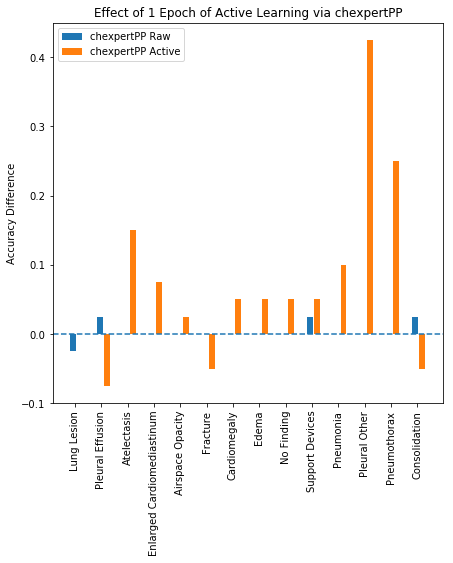

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

WW = 1.25
X = np.arange(len(ALL_TASKS)) * WW
y_raw = np.array([accuracies[t] for t in ALL_TASKS])
y_BERT = np.array([accuracies_cxpPP[t] for t in ALL_TASKS])
y_active = np.array([accuracies_cxpPP_post[t] for t in ALL_TASKS])

mean_delta_BERT_raw = (np.array(y_BERT) - np.array(y_raw)).mean()
std_delta_BERT_raw = (np.array(y_BERT) - np.array(y_raw)).mean()
mean_delta_active_BERT = -(np.array(y_BERT) - np.array(y_active)).mean()
std_delta_active_BERT = -(np.array(y_BERT) - np.array(y_active)).mean()

N = 3
P = 5/100
W = 1/N - P

# ax.bar(X - WW / N, y_raw, width=W, label='CheXpert')
ax.bar(X - WW / N + W + P, y_BERT - y_raw, width = W, label='chexpertPP Raw')
ax.bar(X - WW / N + 2*W + 2*P, y_active - y_raw, width = W, label='chexpertPP Active')

# all_y = list(y_raw) + list(y_BERT) + list(y_active)
# ax.set_ylim((min(all_y)-0.1, max(all_y) + 0.1))

plt.legend()
ax.set_xticks(X)
ax.set_xticklabels(ALL_TASKS)
ax.tick_params(axis='x', rotation=90)

ax.axhline(0, linestyle='dashed', label="CheXpert")
ax.set_ylabel("Accuracy Difference")
ax.set_title("Effect of 1 Epoch of Active Learning via chexpertPP")

print(mean_delta_BERT_raw, mean_delta_active_BERT)

In [94]:
print(np.mean(list(inter_annotator_agreement.values())), np.mean(list(accuracies.values())),
      np.mean(list(accuracies_cxpPP.values())), np.mean(list(accuracies_cxpPP_post.values())),
      np.mean(list(accuracies_cxpPP_post_annotator_2.values())), np.mean(list(accuracies_annotator_2.values())))

0.7821428571428571 0.7160714285714286 0.7196428571428571 0.7910714285714285 0.7125000000000001 0.6982142857142856


### Selecting Set to Annotate

In [96]:
most_uncertain = {}
for task in set(logits_df.columns.get_level_values('Task')):
    most_uncertain_df = logits_df[task].copy()
    # Entropy = E_{p(x)}(-log(p(x)))
    # p(x) = \frac{1}{Z} e^{logit(x)}
    # Entropy = E_{p(x)}-(logit(x) - log(Z)) = (E_{p(x)} -logit(x)) + log(Z)
    # = \sum_{x} \frac{1}{Z} e^{logit(x)} (-logit(x)) + log(Z) 
    # = \frac{-1}{Z} \sum_{x} e^{logit(x)} logit(x)
    logits = most_uncertain_df.values
    probs = np.exp(logits)
    most_uncertain_df['Z'] = probs.sum(axis=1)
    most_uncertain_df['H'] = (
        (-(probs * logits).sum(axis=1) / most_uncertain_df['Z'])
        + np.log(most_uncertain_df['Z'])
    )
    most_uncertain[task] = most_uncertain_df.sort_values(
        by='H', ascending=False).head(400).join(inputs, how='left')
    
with open(os.path.join(DATA_DIR, 'most_uncertain_base.pkl'), mode='wb') as f:
    pickle.dump(most_uncertain, f)

In [97]:
blind_display(most_uncertain['Pneumothorax'])

No Mention  \
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly Lung Lesion Airspace Opacity Edema      Consolidation    Pneumonia         Atelectasis       Pneumothorax      Pleural Effusion Pleural Other Fracture   Support Devices Fold Sentence Number               
0      No Mention       No Mention                 No Mention   No Mention  No Mention       No Mention No Mention       No Mention        No Mention        Uncertain Mention No Mention       No Mention    No Mention No Mention      8    6                       NaN   
                                                                            Negative Mention No Mention No Mention       No Mention        Positive Mention  Positive Mention  Negative Mention No Mention    No Mention No Mention      8    1                       NaN   
       Positive Mention No Mention                 No Mention   No Mention  No Mention       No Mention Negative Mention No Mention        Negative Mention  Negative Mention  Negative Mention No Mention    No Mention No Mention      8    3                       NaN   
       No Mention       No Mention                 No Mention   No Mention  No Mention       No Mention Negative Mention No Mention        Uncertain Mention Uncertain Mention Positive Mention No Mention    No Mention No Mention      8    2                       NaN   
                                                                                                        No Mention       Uncertain Mention No Mention        Uncertain Mention Negative Mention No Mention    No Mention No Mention      8    7                       NaN   

                                                                                                                                                                                                                                                               Uncertain Mention  \
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly Lung Lesion Airspace Opacity Edema      Consolidation    Pneumonia         Atelectasis       Pneumothorax      Pleural Effusion Pleural Other Fracture   Support Devices Fold Sentence Number                      
0      No Mention       No Mention                 No Mention   No Mention  No Mention       No Mention No Mention       No Mention        No Mention        Uncertain Mention No Mention       No Mention    No Mention No Mention      8    6                              NaN   
                                                                            Negative Mention No Mention No Mention       No Mention        Positive Mention  Positive Mention  Negative Mention No Mention    No Mention No Mention      8    1                              NaN   
       Positive Mention No Mention                 No Mention   No Mention  No Mention       No Mention Negative Mention No Mention        Negative Mention  Negative Mention  Negative Mention No Mention    No Mention No Mention      8    3                              NaN   
       No Mention       No Mention                 No Mention   No Mention  No Mention       No Mention Negative Mention No Mention        Uncertain Mention Uncertain Mention Positive Mention No Mention    No Mention No Mention      8    2                              NaN   
                                                                                                        No Mention       Uncertain Mention No Mention        Uncertain Mention Negative Mention No Mention    No Mention No Mention      8    7                              NaN   

                                                                                                                                                                                                                                                               Negative Mention  \
rad_id No Finding       Enlarged Cardiomediastinum Cardiomegaly Lung Lesion Airspace Opacity Edema      Consolidation    Pneumonia         Atelectasis       Pneumo

In [43]:
for task, df in most_uncertain.items():
    df.to_csv(os.path.join(DATA_DIR, '%s_r0_uncertain.csv' % task), sep='\t')